As described in Chollet Deep Learning p145, First pretrain by predicting features from VGG16 model.  Then, learn the weights to apply to correlation/covariance products from predicted, matched filter outputs to cat and dog labels (0 or 1).

In [2]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

    

58892288/58889256 [==============================] - 31s 1us/step


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/sbradley/tensorflow/mlenv/chollet_book/dogs_vs_cats'
train_dir = os.path.join(base_dir, 'train')

validation_dir = os.path.join(base_dir, 'validation')

test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# Runs predict and returns all "matched filter" features output from the pretrained 
# convnet as well
# as the labels for the input images.  These labels are gleaned from the names of the
# cat and dog subdirectories!
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count,4,4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size = batch_size,
        class_mode='binary')
    i=0
    for inputs_batch,labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1) * batch_size] = features_batch
        labels[i*batch_size : (i+1) * batch_size] = labels_batch
        i+=1
        if i*batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

     

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
a=[[1,2,3],[4,5,6],[7,8,9]]
a[1:]  


[[4, 5, 6], [7, 8, 9]]

In [15]:
# Started pretrained extract features above at 5:05.  Done sometime before 5:40
from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

model = models.Sequential()
# Note:  Chollet left out the necessary step of flattening the training features!
# Without flatten, running the fit on model fails on error at bottom of this cell
# shape removes the samples dimension and returns the shape = (4,4,512) dimensions
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(layers.Dense(256, activation='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss= 'binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size= 20,
                   validation_data = (validation_features, validation_labels))
# ValueError before adding Flatten: Error when checking input: 
# expected dense_3_input to have 2 dimensions, but got array with shape (2000, 4, 4, 512)

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6031 - acc: 0.6795 - val_loss: 0.4463 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.4283 - acc: 0.8060 - val_loss: 0.3650 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3600 - acc: 0.8470 - val_loss: 0.3249 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3159 - acc: 0.8775 - val_loss: 0.3021 - val_acc: 0.8930
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2899 - acc: 0.8795 - val_loss: 0.2928 - val_acc: 0.8720
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2557 - acc: 0.9015 - val_loss: 0.2733 - val_acc: 0.9000
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2407 - acc: 0.9055 - val_loss: 0.2661 - val_acc: 0.9020
Epoch 8/30
200

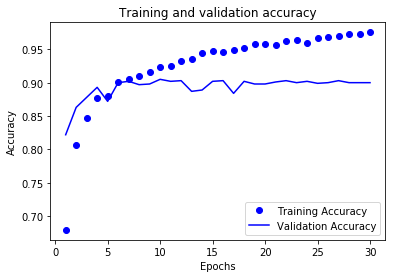

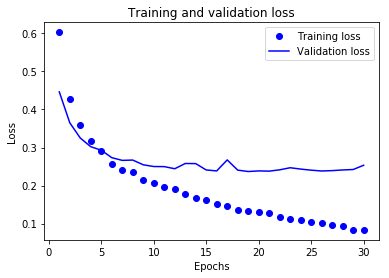

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
training_loss = history.history['loss']
#print("training_loss: ", training_loss) 
validation_loss = history.history['val_loss']
#print("validation_loss: ", validation_loss) 

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Yahoo!   Achieved 90% accuracy in validation data!!  And it was very fast--
less than 40 minutes to fit using the conv_base
And, only 4*30 or 2 minutes to learn the densely connected weights from the output features.  Input to denseley connected layer is 2000 4,4 conv matrices X256